# VR - Motion recognition with simple gestures

In [1]:
import time
start_time = time.time()

## Libraries
* Numpy
* Pandas
* Matplotlib
* PyTorch

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.onnx

from xgboost import XGBClassifier

## Importing scripts

In [3]:
from utils.data import Data
from utils.hardware import Hardware
from utils.vr_gesture_recognizer import VRGestureRecognizer
from utils.plot import Plot
from utils.model_utils import ModelUtils

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.11/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.11/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.11/site-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


## Loading data

We first begin by loading all the data from the csv files. We retrieve **all the raw data** into **a single numpy array**. We retrieve the **labels** into **a separate array**.

In [4]:
# Define base data directory
base_dir: str = os.path.join(os.getcwd(), 'data')

# Load data
tuple_data: tuple[list[pd.DataFrame], np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
pd_data: list[pd.DataFrame] = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]
print("Classes:", classes)

0 OUI
1 NON
2 VRAI
3 FAUX
Classes: ['OUI' 'NON' 'VRAI' 'FAUX']


### Example Data

In [5]:
pd_data[0].head()

,Head_pos_x,Head_pos_y,Head_pos_z,Head_rot_x,Head_rot_y,Head_rot_z,LeftHand_pos_x,LeftHand_pos_y,LeftHand_pos_z,LeftHand_rot_x,...,RightRing3_rot_z,RightThumb1_rot_x,RightThumb1_rot_y,RightThumb1_rot_z,RightThumb2_rot_x,RightThumb2_rot_y,RightThumb2_rot_z,RightThumb3_rot_x,RightThumb3_rot_y,RightThumb3_rot_z
0,-0.005309,1.588150,0.004895,28.18738,357.7555,1.233561,-0.278133,0.810004,-0.108239,351.7242,...,350.1419,27.19806,341.7921,337.9047,353.1641,7.021258,315.9565,6.055505,354.4477,314.7976
1,-0.005352,1.588086,0.004848,28.18189,357.7465,1.248143,-0.278401,0.809932,-0.108324,351.7806,...,350.2690,27.18621,341.7753,337.8988,353.1659,7.019536,315.9209,6.055294,354.4479,314.7942
2,-0.005398,1.588020,0.004816,28.18045,357.7399,1.260971,-0.278663,0.809862,-0.108401,351.8357,...,350.3961,27.17978,341.8129,337.9211,353.1688,7.016729,315.8626,6.054836,354.4484,314.7863
3,-0.005430,1.587938,0.004776,28.18449,357.7346,1.250171,-0.278736,0.809936,-0.108116,351.8196,...,350.5227,27.17271,341.8486,337.9416,353.1716,7.013957,315.8050,6.054352,354.4488,314.7783
4,-0.005462,1.587839,0.004742,28.19781,357.7418,1.254437,-0.278807,0.810010,-0.107829,351.8105,...,350.8220,27.17937,341.8719,337.9523,353.1733,7.012261,315.7700,6.060657,354.4425,314.8842


### From Pandas to Numpy

For ease of use, we will convert the Pandas dataframe to a Numpy array. This will allow us to use the data with PyTorch, thus creating tensors with more simplicity.

In [6]:
data: np.ndarray = Data.convert_to_numpy(pd_data)

## Settings and hyperparameters ...

Here we define the **settings** and **hyperparameters** for the model. Here are the ones we will use for our use case:
* Device: the device on which the model will be trained. We will use a GPU if available, otherwise we will use the CPU.
* Batch size: the number of samples that will be propagated through the network at once.
* Number of epochs: the number of times the entire dataset will be passed through the network.
* Learning rate: the step size at each iteration while moving toward a minimum of a loss function.
* Hidden size: the size of the hidden layer in the fully connected part of the network.
* Number of labels: the number of labels in the dataset.

In [7]:
DEVICE = Hardware.device()
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4
HIDDEN_SIZE = 128
NUM_LABELS = classes.shape[0]

# Loss function
loss_fn = nn.CrossEntropyLoss()

## Model - Convolutional Neural Network

### Reproducibilty - PyTorch seed

As we want to be able to reproduce our results, we need to set the seed for the random number generator of PyTorch. This is especially important for the initialization of the weights of the neural network.

In [8]:
torch.manual_seed(42)

### Training

  0%|          | 0/100 [00:00<?, ?it/s]

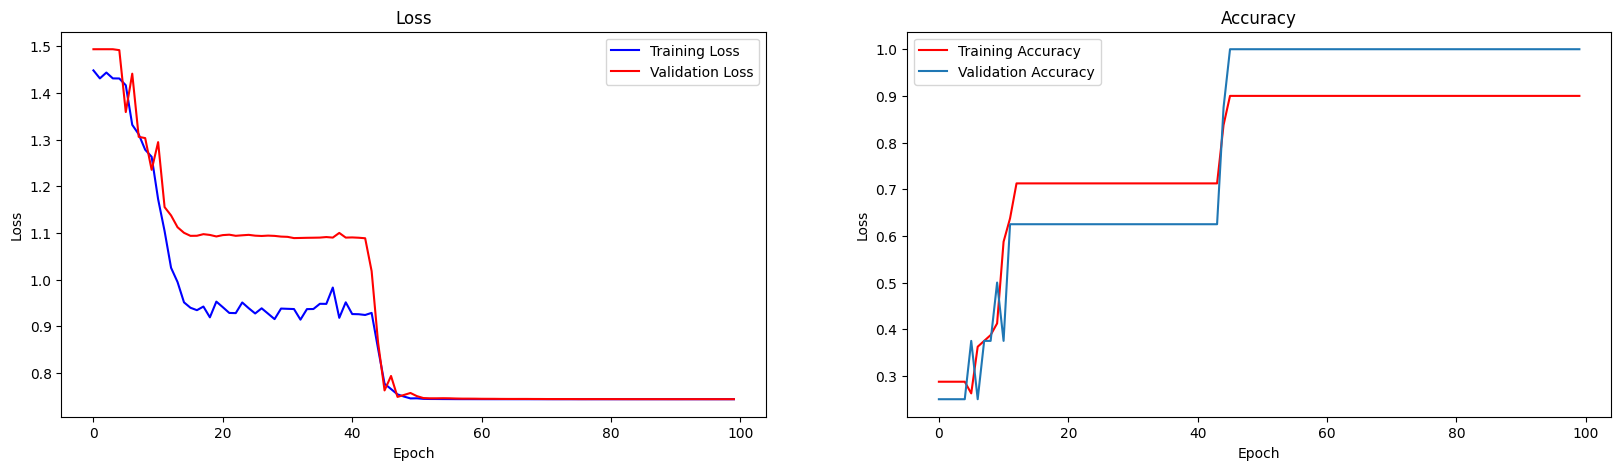

In [9]:
gesture_recognizer = VRGestureRecognizer(hidden_size=HIDDEN_SIZE, num_classes=NUM_LABELS).to(Hardware.device(), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

gesture_recognizer.compile(loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

gesture_recognizer.plot_history()

### Evaluation

We can now evaluate the model on the test set. We will use the accuracy and the loss of the model as metrics.

In [10]:
test_loss, test_accuracy = gesture_recognizer.to(Hardware.device()).evaluate(X_test, y_test)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy * 100:.2f}%")

Loss: 0.74 | Accuracy: 100.00%


### Results

Let's first make predictions on our test set.

In [11]:
y_pred = gesture_recognizer.to(Hardware.device()).predict(X_test).cpu().numpy().astype(dtype=np.int32)

#### Confusion matrix

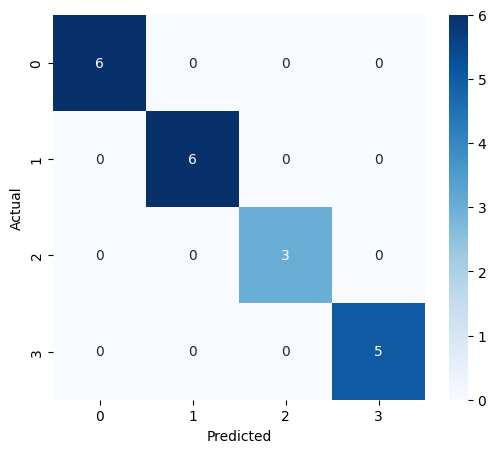

In [12]:
gesture_recognizer_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(gesture_recognizer_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [13]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         6
         NON       1.00      1.00      1.00         6
        VRAI       1.00      1.00      1.00         3
        FAUX       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Exporting the model

Before exporting the model, we will first clean the model saving directory.

In [14]:
if os.path.exists('models'):
    for f in os.listdir('models'):
        os.remove(os.path.join('models', f))
else:
    os.mkdir('models')

In [15]:
gesture_recognizer.export_to_onnx(path='models/vr_gesture_recognizer.onnx', data_shape=data.shape[1:])

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Resetting datasets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=16)

## XGBoost - Extreme Gradient Boosting

### Model initialization

In [17]:
xgb_classifier = XGBClassifier(
    n_estimators=100,
    max_depth=128,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=classes.shape[0]
)

### Cross validation

In [18]:
kFold = KFold(n_splits=5, shuffle=True, random_state=20)
scores = cross_val_score(xgb_classifier, X_train.reshape(X_train.shape[0], -1), y_train, cv=kFold, scoring='accuracy')

print(f"Cross validation mean accuracy: {scores.mean() * 100:.2f}%\n")

Cross validation mean accuracy: 97.50%



### Train and predict

In [19]:
xgb_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = xgb_classifier.predict(X_test.reshape(X_test.shape[0], -1))

### Results

#### Confusion matrix (heatmap)

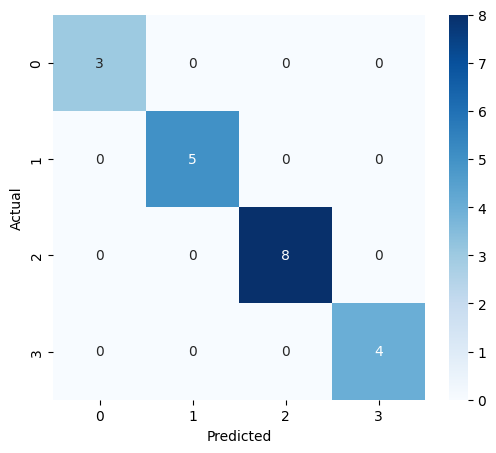

In [20]:
xgb_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(xgb_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [21]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         3
         NON       1.00      1.00      1.00         5
        VRAI       1.00      1.00      1.00         8
        FAUX       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [22]:
ModelUtils.save_sklearn_model_to_onnx(
    xgb_classifier,
    path='models/xgb_gesture_recognizer.onnx',
    data_shape=data.shape[1:],
    is_xgboost=True
)

## Random Forest Classifier

### Model initialization

In [23]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=64,
    class_weight='balanced',
    random_state=16
)

### Cross Validation

In [24]:
kFold = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_val_score(rf_classifier, X_train.reshape(X_train.shape[0], -1), y_train, cv=kFold, scoring='accuracy')

print(f"Cross validation mean accuracy: {scores.mean() * 100:.2f}%\n")

Cross validation mean accuracy: 100.00%



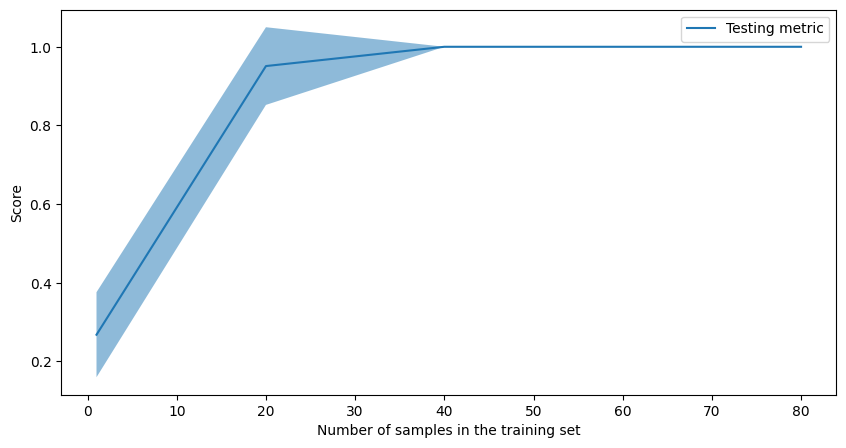

In [25]:
_, ax = plt.subplots(figsize=(10, 5))
LearningCurveDisplay.from_estimator(
    rf_classifier,
    data.reshape(data.shape[0], -1),
    labels,
    cv= ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.01, 1.0, 5),
    ax=ax
)
plt.show()

### Train and predict

In [26]:
rf_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf_classifier.predict(X_test.reshape(X_test.shape[0], -1))

### Results

#### Confusion matrix (heatmap)

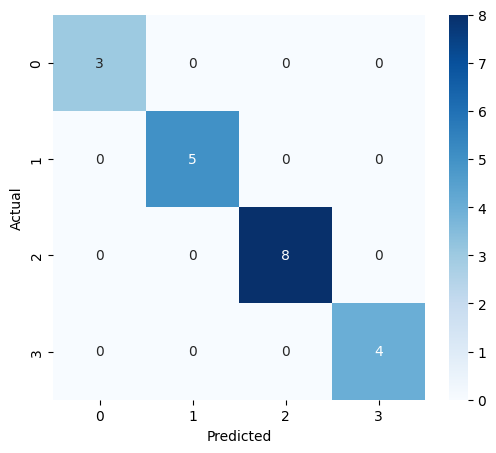

In [27]:
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(rf_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [28]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         3
         NON       1.00      1.00      1.00         5
        VRAI       1.00      1.00      1.00         8
        FAUX       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Save / Export the model

In [29]:
ModelUtils.save_sklearn_model_to_onnx(rf_classifier, path='models/random_forest.onnx', data_shape=data.shape[1:])

## Decision Tree Classifier

### Model initialization

In [30]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=128,
    class_weight='balanced',
    random_state=42
)

### Cross Validation

In [31]:
kFold = KFold(n_splits=5, shuffle=True, random_state=10)
scores = cross_val_score(dt_classifier, X_train.reshape(X_train.shape[0], -1), y_train, cv=kFold, scoring='accuracy')

print(f"Cross validation mean accuracy: {scores.mean() * 100:.2f}%\n")

Cross validation mean accuracy: 100.00%



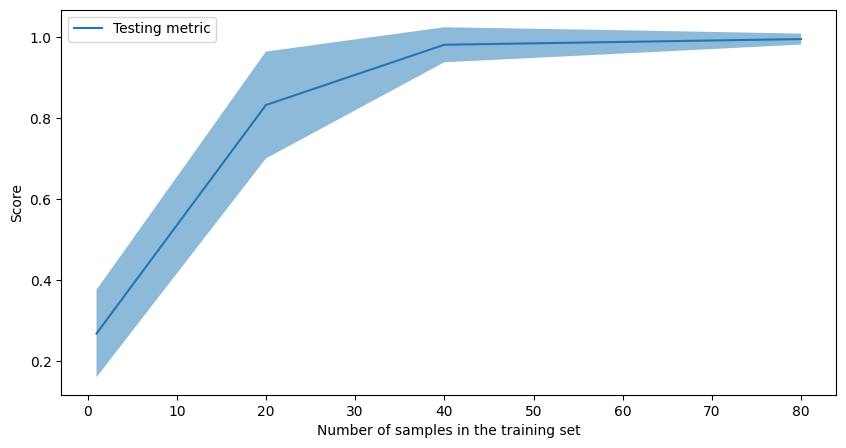

In [32]:
_, ax = plt.subplots(figsize=(10, 5))
LearningCurveDisplay.from_estimator(
    dt_classifier,
    data.reshape(data.shape[0], -1),
    labels,
    cv= ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.01, 1.0, 5),
    ax=ax
)
plt.show()

### Train and predict

In [33]:
dt_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = dt_classifier.predict(X_test.reshape(X_test.shape[0], -1))

### Results

#### Confusion matrix (heatmap)

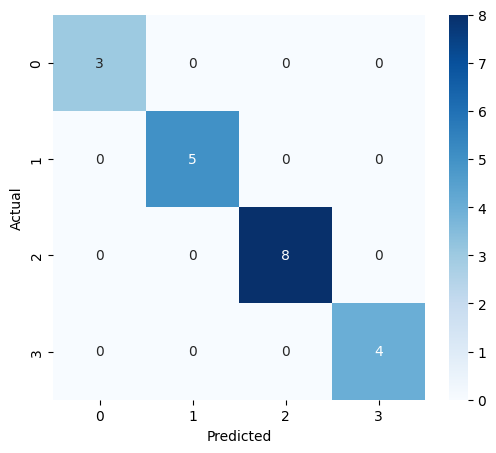

In [34]:
dt_confusion_matrix = confusion_matrix(y_test, y_pred)
Plot.plot_confusion_matrix(dt_confusion_matrix, fig_size=(6, 5))

#### Classification report

In [35]:
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         3
         NON       1.00      1.00      1.00         5
        VRAI       1.00      1.00      1.00         8
        FAUX       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Save / Export the model

In [36]:
ModelUtils.save_sklearn_model_to_onnx(dt_classifier, path='models/decision_tree.onnx', data_shape=data.shape[1:])

## Time Execution

In [37]:
end_time = time.time()
print(f"--- {int((end_time - start_time) / 60)} minutes, {int((end_time - start_time) % 60)} seconds ---")

--- 0 minutes, 57 seconds ---
